In [1]:
import h5py
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [9]:
filename = "camera_intrinsics.h5"
main_K, main_distortion = None, None

#Extracts the intrinsic K matrix and distortion vector from the h5 file
with h5py.File(filename, "r") as data:

    main_K = np.array(data["main"]["K"])
    main_distortion = np.array(data["main"]["distortion"])

#Reference: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

#Uses the intrinsics above to create an undistorted image and save it in a separate file under "proc_main"
images = os.listdir("main")
for file in images:
    img = cv.imread("main/" + file)
    if (img is not None):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv.getOptimalNewCameraMatrix(main_K, main_distortion, (w,h), 1, (w,h))
        undistorted = cv.undistort(img, main_K, main_distortion, None, newcameramtx)

        # crop image
        x, y, w, h = roi
        undistorted = undistorted[y:y+h, x:x+w]

        new_name = "proc_main/proc_" + file
        cv.imwrite(new_name, undistorted)
    

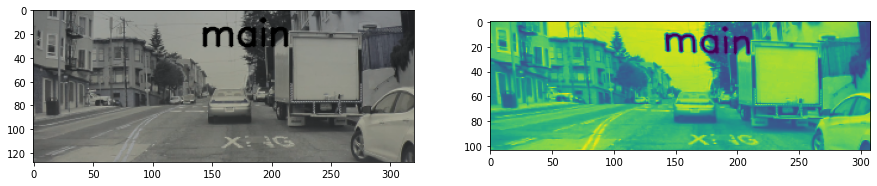

In [247]:
#plots the original and undistorted grayscale image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

dist = cv.imread("main/0844.png")
undist = cv.imread("proc_main/proc_0844.png")
gray = cv.cvtColor(undist, cv.COLOR_BGR2GRAY)

ax[0].imshow(dist)
ax[1].imshow(r)

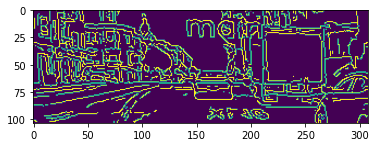

In [248]:
# (Unsuccessful) Canny Filter
blur_gray = cv.GaussianBlur(gray,(3, 3), 0) 
img_can = cv.Canny(blur_gray, 45, 50) #threshold1 = 45, threshold2 = 50
plt.imshow(img_can)

In [249]:
#apply sobel https://medium.com/swlh/computer-vision-advanced-lane-detection-through-thresholding-8a4dea839179

#by trial and error, take a gradient with dx=1, dy=1
sobel = cv.Sobel(gray, cv.CV_64F, 1, 1)

#we have to take absolute value, otherwise negative gradients will be taken as 0 when converting to uint8
sobel_abs = np.absolute(sobel) 
conv_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))

binary = np.zeros_like(conv_sobel) #create a binary mask of all zeroes

#make binary pixel 1 if the sobel pixel falls within the chosen threshold
binary[(conv_sobel >= 15) & (conv_sobel <= 75)] = 1 

#make binary pixel 0 if it is outside of relevant image region
binary[0:60, :] = 0
binary[:, 150:] = 0

Text(0.5, 1.0, 'Binary for First Order dx, dy')

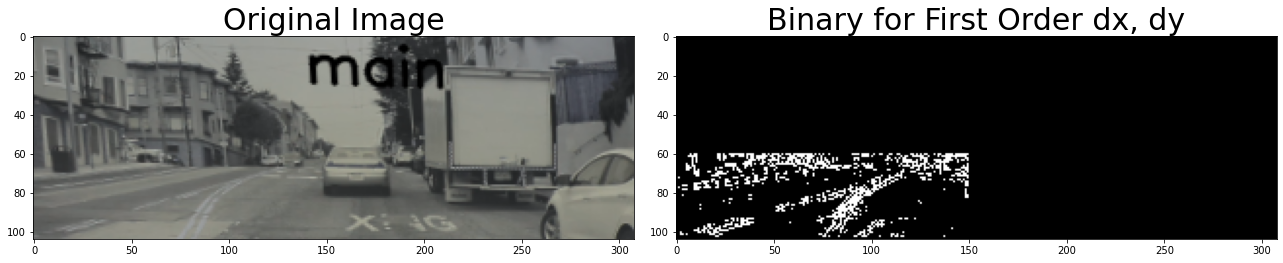

In [250]:
# Plot the result
f, ax = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax[0].imshow(undist)
ax[0].set_title('Original Image', fontsize=30)
ax[1].imshow(binary, cmap='gray')
ax[1].set_title('Binary for First Order dx, dy', fontsize=30)

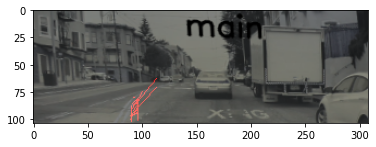

In [251]:

#https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

#create empty image
line_image = np.copy(undist) * 0

#Hough Lines, rho=1 and threshold=1
lines = cv.HoughLinesP(in_bound, 1, np.pi/180, 1, np.array([]), minLineLength=1, maxLineGap=50)

#Add hough lines to canvas (each line is made up of two endpoints, x1, y1  and x2, y2)
for line in lines:
    for x1, y1, x2, y2 in line:
        pts = np.array([[x1, y1 ], [x2, y2]], np.int32)
        cv.polylines(line_image, [pts], True, (255,0,0))

#Add the canvas w/ lines to the undistorted image and plot
lines_edges = cv.addWeighted(undist, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)

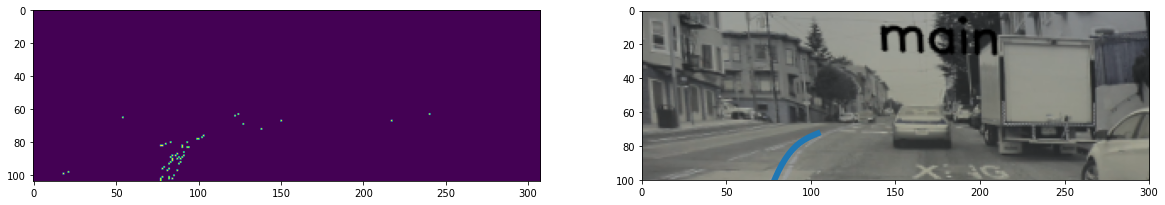

In [258]:
#NEW METHOD: color bounds
lower_bound = np.array([140, 140, 140]) #upper and lower RGB bounds
upper_bound = np.array([148, 148, 148])

#find all pixels within this color range, in the relevant region of the image
in_bound = cv.inRange(undist, lower_bound, upper_bound)
in_bound[0:60] = 0

#extract coordinates of each nonzero pixel
pts = np.array([(x, y) for y in range(len(in_bound[0])) for x in range(len(in_bound)) if in_bound[x, y] > 0])
ptsx = [pt[0] for pt in pts]
ptsy = [pt[1] for pt in pts]

#fit the points to a degree-3 polynomial
fit = np.polyfit(ptsx, ptsy, 3)
curve = np.poly1d(fit)
x_range = np.linspace(0, len(in_bound))
y_range = curve(x_range)

#plotting pixels within the color bounds [0] and the fit overlaid on the undistorted image [1]
fig, ax = plt.subplots(1, 2, figsize = (20, 15))

ax[0].imshow(in_bound)
ax[1].plot(x_range, y_range, linewidth=6)
ax[1].set_xlim(0, 300)
ax[1].set_ylim(0, 100)

ax[1].imshow(undist)
ax[1].invert_yaxis()

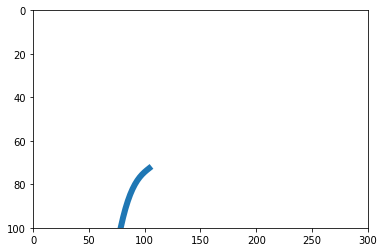

In [259]:
#plotting just the fit
plt.plot(x_range, y_range, linewidth=6)
plt.xlim(0, 300)
plt.ylim(0, 100)
plt.gca().invert_yaxis()
